In [2]:
import h5py
import requests
import numpy as np
import timeit
import matplotlib
import pymc3 as pm
from numpy import genfromtxt
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from astroML.linear_model import LinearRegressionwithErrors
from astroML.linear_model import PolynomialRegression
from sklearn.model_selection import train_test_split

import numpy.random as ra

In [3]:
#formatting

plt.rcParams.update(plt.rcParamsDefault)
params = {'backend': 'pdf',
        'axes.labelsize': 10,
        'lines.markersize': 4,
        'font.size': 10,
        'xtick.major.size':6,
        'xtick.minor.size':3,
        'ytick.major.size':6,
        'ytick.minor.size':3,
        'xtick.major.width':0.5,
        'ytick.major.width':0.5,
        'xtick.minor.width':0.5,
        'ytick.minor.width':0.5,
        'lines.markeredgewidth':1,
        'axes.linewidth':1.2,
        'legend.fontsize': 7,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'savefig.dpi':200,
        'path.simplify':True,}
plt.rcParams.update(params)

In [4]:
#accessing the data
h5f = h5py.File('illustrisData7-6-20.h5','r')
h5f2 = h5py.File('illustrisDataPrimaryFlag8-6-20.h5','r')

ids = h5f['ids'][:]
snaps = h5f['snaps'][:]
mergerIDs = h5f['mergerIDs'][:]
mergerSnaps = h5f['mergerSnaps'][:]
m1 = h5f['m1'][:]
m2 = h5f['m2'][:]
z = h5f['z'][:]
scale = h5f['scale'][:]
bhmdot = h5f['bhmdot'][:]
gasmetallicity = h5f['gasmetallicity'][:]
massinrad = h5f['massinrad'][:]
massinradtype = h5f['massinradtype'][:]
sfrinrad = h5f['sfrinrad'][:]
spin = h5f['spin'][:]
starmetallicity = h5f['starmetallicity'][:]
stellarphotometrics = h5f['stellarphotometrics'][:]
veldisp = h5f['veldisp'][:]
massinhalfrad = h5f['massinhalfrad'][:]
primary = h5f2['primary'][:]


badIndices = np.array([1933,2820,3006,3463])
ids = np.delete(ids,badIndices,0)
snaps = np.delete(snaps,badIndices,0)
mergerIDs = np.delete(mergerIDs,badIndices,0)
mergerSnaps = np.delete(mergerSnaps,badIndices,0)
m1 = np.delete(m1,badIndices,0)
m2 = np.delete(m2,badIndices,0)
z = np.delete(z,badIndices,0)
scale = np.delete(scale,badIndices,0)
bhmdot = np.delete(bhmdot,badIndices,0)
gasmetallicity = np.delete(gasmetallicity,badIndices,0)
massinrad = np.delete(massinrad,badIndices,0)
massinradtype = np.delete(massinradtype,badIndices,0)
sfrinrad = np.delete(sfrinrad,badIndices,0)
spin = np.delete(spin,badIndices,0)
starmetallicity = np.delete(starmetallicity,badIndices,0)
stellarphotometrics = np.delete(stellarphotometrics,badIndices,0)
veldisp = np.delete(veldisp,badIndices,0)
massinhalfrad = np.delete(massinhalfrad,badIndices,0)
primary = np.delete(primary,badIndices,0)

h5f.close()
h5f2.close()


h = 0.7

m1 = m1 / (1.988*(10**33)) #grams to M⊙
m2 = m2 / (1.988*(10**33))  #grams to M⊙
chirpM = ((m1*m2)**(3/5))/((m1+m2)**(1/5))
redshift = (1-scale)/scale
bhmdot *= (10.223)  #10**10M⊙/(o.978Gyr) to M⊙/yr
gasmetallicity /= (0.0134)  #conversion to Metallicity⊙ from value on Wikipedia
massinrad = (massinrad * (10**10) / h)  #10**10M⊙/h to M⊙
massinradtype = (massinradtype * (10**10) / h)  #10**10M⊙/h to M⊙
spinResult = np.zeros(ids.size)  #calculating magnititude of spin
for i in range(ids.size):
    spinResult[i] = np.linalg.norm(spin[i,:])
spinResult /= h  #(kpc)(km/s)/h to (kpc)(km/s)
starmetallicity /= (0.0134) #conversion to Metallicity⊙ from value on Wikipedia
massinhalfrad = (massinhalfrad* (10**10) / h)

grcolor = stellarphotometrics[:,4] - stellarphotometrics[:,5]


indexOfMoreThan50 = np.load("indexOfMoreThan50.npy")
DP_i = np.load("DP.npy")

In [5]:
my_data = genfromtxt('MandMdata.csv', delimiter=',')
mbh = my_data[1:,2]
mbh_lower = my_data[1:,3]
mbh_upper = my_data[1:,4]
sigma = my_data[1:,6]
sigma_lower = my_data[1:,7]
sigma_upper = my_data[1:,8]
galaxy_type = my_data[1:,10] #0:spiral, 1:s0, 2:elliptical

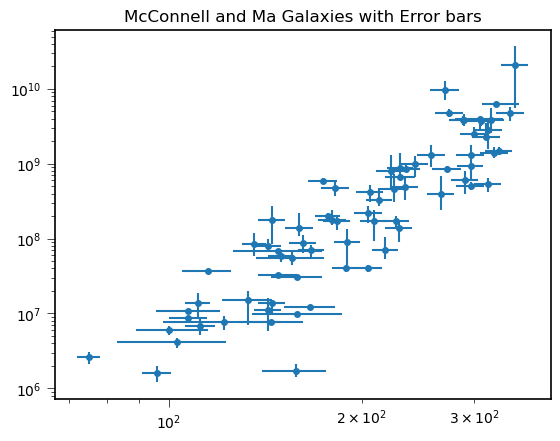

In [6]:
#plotting McConnell and Ma Galaxies with error bars
plt.errorbar(sigma, mbh, yerr=(mbh-mbh_lower, mbh_upper-mbh), 
             xerr=(sigma-sigma_lower, sigma_upper-sigma), fmt='o')
plt.title("McConnell and Ma Galaxies with Error bars")
plt.xscale('log')
plt.yscale('log')
plt.show()

## Regression

In [7]:
#sum squared error
def error(y_pred, y_true):
    return np.sum(np.power(y_true-y_pred,2))

In [8]:
#McConnell and Ma galaxies
model1 = LinearRegression(normalize=True)
#the linear regression with error did not work
#astromodel1 = LinearRegressionwithErrors()

x_train1 = np.log10(sigma)
y_train1 = np.log10(mbh)
x_error1 = np.log10((sigma_upper-sigma_lower)/2)
y_error1 = np.log10((mbh_upper-mbh_lower)/2)

X = x_train1[:, None]
y = y_train1

x_train1,x_test1,y_train1,y_test1=train_test_split(X,y,test_size=0.2,random_state=123)

model1.fit(x_train1, y_train1)
#astromodel1.fit(X,y,y_error1,x_error1)

y_pred_1 = model1.predict(x_test1)
print(model1.score(x_test1, y_test1)

0.755096180499846


In [39]:
model1_1 = LinearRegression(normalize=True)
x_train1_1 = np.log10(sigma)
y_train1_1 = np.log10(mbh)

X = x_train1_1[:, None]
y = y_train1_1

model1_1.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [9]:
#Illustris Galaxies
model2 = LinearRegression(normalize=True)
astromodel_d2 = PolynomialRegression(degree=2)
astromodel_d3 = PolynomialRegression(degree=3)
astromodel_d4 = PolynomialRegression(degree=4)
astromodel_d5 = PolynomialRegression(degree=4)

x_train2 = np.log10(veldisp[massinradtype[:,3]!=0])
y_train2 = np.log10(massinradtype[:,3][massinradtype[:,3]!=0])

X = x_train2[:, None]
y = y_train2

x_train2,x_test2,y_train2,y_test2=train_test_split(X,y,test_size=0.2,random_state=123)

model2.fit(x_train2, y_train2)
astromodel_d2.fit(x_train2, y_train2)
astromodel_d3.fit(x_train2, y_train2)
astromodel_d4.fit(x_train2, y_train2)
astromodel_d5.fit(x_train2, y_train2)

y_pred2 = model2.predict(x_test2)
print("linear error: " + str(error(y_test2,y_pred2)))
y_pred2 = astromodel_d2.predict(x_test2)
print("degree 2 error: " + str(error(y_test2,y_pred2)))
y_pred2 = astromodel_d3.predict(x_test2)
print("degree 3 error: " + str(error(y_test2,y_pred2)))
y_pred2 = astromodel_d4.predict(x_test2)
print("degree 4 error: " + str(error(y_test2,y_pred2)))
y_pred2 = astromodel_d5.predict(x_test2)
print("degree 5 error: " + str(error(y_test2,y_pred2)))

linear error: 101.36731213050258
degree 2 error: 101.27444631914877
degree 3 error: 93.26196644041792
degree 4 error: 93.49379816603877
degree 5 error: 93.49379816603877


In [10]:
coef_d3 = astromodel_d3.coef_
coef_d4 = astromodel_d4.coef_

In [11]:
#Illustris Galaxies with detection probability > 50%
model3 = LinearRegression(normalize=True)

nonZeroMoreThan50 = np.where(massinradtype[:,3][indexOfMoreThan50]!=0)[0]

x_train3 = np.log10(veldisp[indexOfMoreThan50][nonZeroMoreThan50][DP_i[nonZeroMoreThan50]>0.5])
y_train3 = np.log10(massinradtype[:,3][indexOfMoreThan50][nonZeroMoreThan50][DP_i[nonZeroMoreThan50]>0.5])

X = x_train3[:, None]
y = y_train3

model3.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [12]:
#Illustris Galaxies with detection probability > 0.001%
model4 = LinearRegression(normalize=True)

nonZeroMoreThan50 = np.where(massinradtype[:,3][indexOfMoreThan50]!=0)[0]

x_train4 = np.log10(veldisp[indexOfMoreThan50][nonZeroMoreThan50][DP_i[nonZeroMoreThan50]>0.00001])
y_train4 = np.log10(massinradtype[:,3][indexOfMoreThan50][nonZeroMoreThan50][DP_i[nonZeroMoreThan50]>0.00001])

X = x_train4[:, None]
y = y_train4

model4.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [13]:
#Spiral McConnell and Ma Galaxies
model5 = LinearRegression(normalize=True)

x_train5 = np.log10(sigma[galaxy_type==0])
y_train5 = np.log10(mbh[galaxy_type==0])

X = x_train5[:, None]
y = y_train5

model5.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [14]:
#s0 McConnell and Ma Galaxies (morphology in the middle)
model6 = LinearRegression(normalize=True)

x_train6 = np.log10(sigma[galaxy_type==1])
y_train6 = np.log10(mbh[galaxy_type==1])

X = x_train6[:, None]
y = y_train6

model6.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [15]:
#Elliptical McConnell and Ma Galaxies
model7 = LinearRegression(normalize=True)

x_train7 = np.log10(sigma[galaxy_type==2])
y_train7 = np.log10(mbh[galaxy_type==2])

X = x_train7[:, None]
y = y_train7

model7.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [40]:
#all the regressions
x = np.linspace(1.5, 2.8, 100)
y1 = model1_1.coef_[0]*x + model1_1.intercept_
y2 = model2.coef_[0]*x + model2.intercept_
y3 = model3.coef_[0]*x + model3.intercept_
y4 = model4.coef_[0]*x + model4.intercept_
y5 = model5.coef_[0]*x + model5.intercept_
y6 = model6.coef_[0]*x + model6.intercept_
y7 = model7.coef_[0]*x + model7.intercept_
y8 = coef_d3[3]*(x**3) + coef_d3[2]*(x**2) + coef_d3[1]*x + coef_d3[0]
y9 = coef_d4[4]*(x**4) + coef_d4[3]*(x**3) + coef_d4[2]*(x**2) + coef_d4[1]*x + coef_d4[0]
y = 8.32 + 5.64*(np.log10((10**x)/(200)))

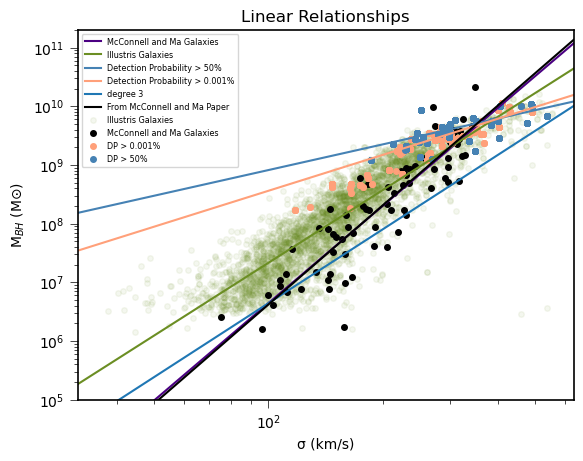

In [42]:
plt.scatter(veldisp, massinradtype[:,3], label="Illustris Galaxies", 
            color = 'olivedrab', alpha =0.07, marker='o')
plt.scatter(sigma, mbh, color='black', label="McConnell and Ma Galaxies")
plt.scatter(veldisp[indexOfMoreThan50][DP_i>0.00001], massinradtype[:,3][indexOfMoreThan50][DP_i>0.00001],
            label="DP > 0.001%", alpha = 1, color = "lightsalmon")
plt.scatter(veldisp[indexOfMoreThan50][DP_i>0.5], massinradtype[:,3][indexOfMoreThan50][DP_i>0.5],
            label="DP > 50%", alpha = 1, color = "steelblue")
plt.plot(10**x,10**y1,color='indigo', label='McConnell and Ma Galaxies')
plt.plot(10**x,10**y2,color='olivedrab', label = 'Illustris Galaxies')
plt.plot(10**x,10**y3,color='steelblue', label = 'Detection Probability > 50%')
plt.plot(10**x,10**y4,color='lightsalmon', label = 'Detection Probability > 0.001%')
#plt.plot(10**x,10**y5,label="degree 3")
plt.plot(10**x,10**y,color='black', label= 'From McConnell and Ma Paper')
plt.title('Linear Relationships')
plt.xlabel('σ (km/s)')
plt.ylabel('M$_{BH}$ (M⊙)')
plt.xscale('log')
plt.yscale('log')
plt.xlim(10**1.5, 10**2.8)
plt.ylim(10**5,2*10**11)
plt.legend(fontsize='xx-small')
plt.show()

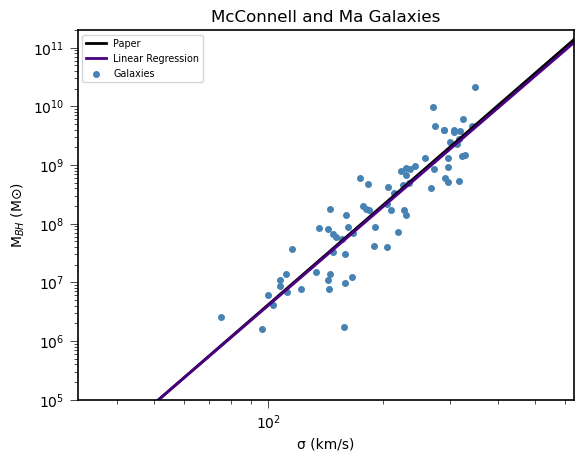

In [27]:
plt.scatter(sigma, mbh, color='steelblue', label="Galaxies")
plt.plot(10**x,10**y,color='black', label= 'Paper', linewidth=2)
plt.plot(10**x,10**y1,color='indigo', label='Linear Regression', linewidth=2)
plt.title('McConnell and Ma Galaxies')
plt.xlabel('σ (km/s)')
plt.ylabel('M$_{BH}$ (M⊙)')
plt.xscale('log')
plt.yscale('log')
plt.xlim(10**1.5, 10**2.8)
plt.ylim(10**5,2*10**11)
plt.legend(fontsize='x-small')
#plt.savefig('M&MGalaxies.pdf', bbox_inches='tight', dpi=400)
plt.show()

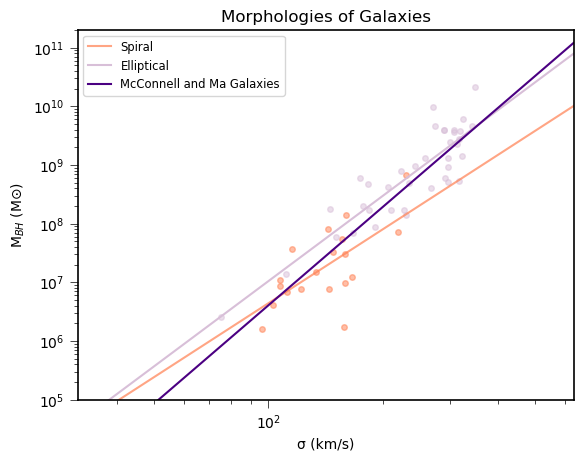

In [30]:
plt.scatter(sigma[galaxy_type==0], mbh[galaxy_type==0], 
            color='coral', alpha=0.5)
#plt.scatter(10**x_train1[galaxy_type==1], 10**y_train1[galaxy_type==1], 
#            color='skyblue', alpha=0.5, label="maser")
plt.scatter(sigma[galaxy_type==2], mbh[galaxy_type==2], 
            color='thistle', alpha=0.5)
plt.plot(10**x,10**y5,color='coral', alpha=0.7,label='Spiral')
#plt.plot(10**x,10**y6,color='skyblue', label='maser')
plt.plot(10**x,10**y7,color='thistle', label='Elliptical')
plt.plot(10**x,10**y1,color='indigo', label='McConnell and Ma Galaxies')
#plt.plot(10**x,10**y8, color='indianred', label="Degree 3 Polynomial")
plt.title('Morphologies of Galaxies')
plt.xlabel('σ (km/s)')
plt.ylabel('M$_{BH}$ (M⊙)')
plt.xscale('log')
plt.yscale('log')
plt.xlim(10**1.5, 10**2.8)
plt.ylim(10**5,2*10**11)
plt.legend(fontsize='small')
plt.savefig('MorphologyDifferences.pdf', bbox_inches='tight', dpi=400)
plt.show()

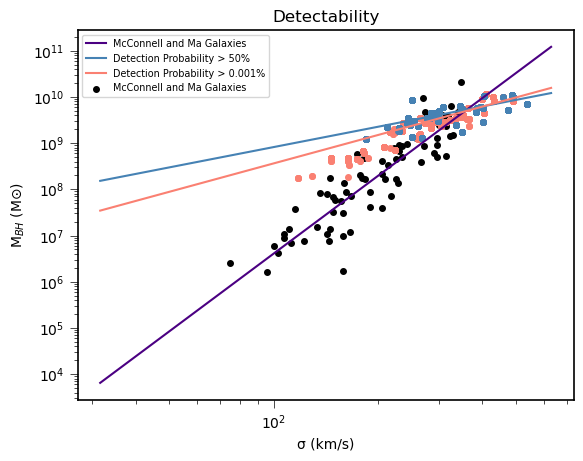

In [31]:
plt.scatter(sigma, mbh, color='black', label="McConnell and Ma Galaxies")
plt.scatter(veldisp[indexOfMoreThan50][DP_i>0.00001], massinradtype[:,3][indexOfMoreThan50][DP_i>0.00001],
            alpha = 1, color = "salmon")
plt.scatter(veldisp[indexOfMoreThan50][DP_i>0.5], massinradtype[:,3][indexOfMoreThan50][DP_i>0.5],
            alpha = 1, color = "steelblue")
plt.plot(10**x,10**y1,color='indigo', label='McConnell and Ma Galaxies')
plt.plot(10**x,10**y3,color='steelblue', label = 'Detection Probability > 50%')
plt.plot(10**x,10**y4,color='salmon', label = 'Detection Probability > 0.001%')
plt.title('Detectability')
plt.xlabel('σ (km/s)')
plt.ylabel('M$_{BH}$ (M⊙)')
plt.xscale('log')
plt.yscale('log')
#plt.xlim(10**1.5, 10**2.8)
#plt.ylim(10**5,2*10**11)
plt.legend(fontsize='x-small')
plt.savefig('Detectability.pdf', bbox_inches='tight', dpi=400)
plt.show()

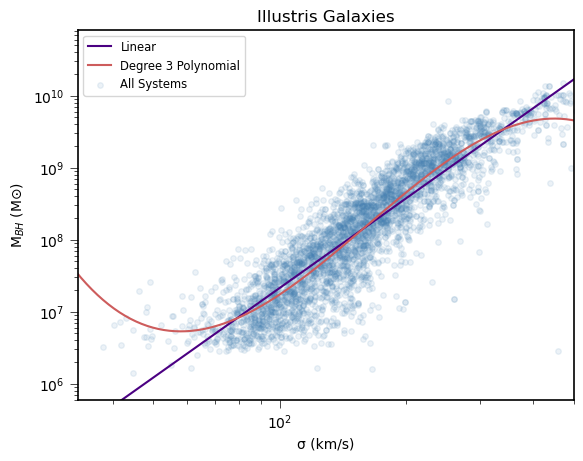

In [32]:
plt.scatter(veldisp, massinradtype[:,3], label="All Systems", 
            color = 'steelblue', alpha =0.1, marker='o')
plt.plot(10**x,10**y2, color='indigo', label = 'Linear')
plt.plot(10**x,10**y8, color='indianred', label="Degree 3 Polynomial")
#plt.plot(10**x,10**y9, label='degree 4')
plt.title('Illustris Galaxies')
plt.xlabel('σ (km/s)')
plt.ylabel('M$_{BH}$ (M⊙)')
plt.xscale('log')
plt.yscale('log')
plt.xlim(3.3e1, 5e2)
plt.ylim(6e5)
plt.legend(fontsize='small')
#plt.savefig('IllustrisLin&Poly.pdf', bbox_inches='tight', dpi=400)
plt.show()

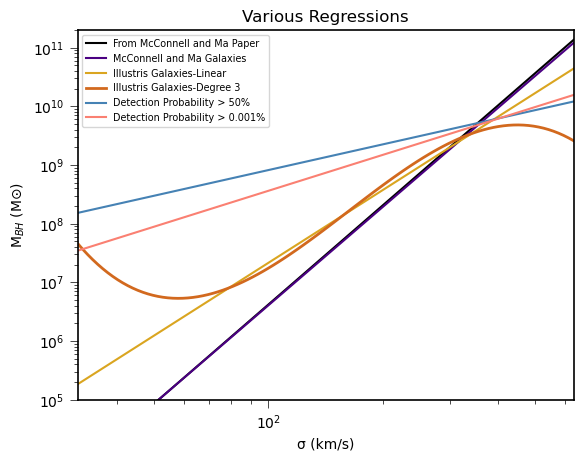

In [33]:
plt.plot(10**x,10**y,color='black', label= 'From McConnell and Ma Paper')
plt.plot(10**x,10**y1,color='indigo', label='McConnell and Ma Galaxies')
plt.plot(10**x,10**y2,color='goldenrod', label = 'Illustris Galaxies-Linear')
plt.plot(10**x,10**y8,label="Illustris Galaxies-Degree 3", linewidth=2, color='chocolate')
plt.plot(10**x,10**y3,color='steelblue', label = 'Detection Probability > 50%')
plt.plot(10**x,10**y4,color='salmon', label = 'Detection Probability > 0.001%')
plt.title('Various Regressions')
plt.xlabel('σ (km/s)')
plt.ylabel('M$_{BH}$ (M⊙)')
plt.xscale('log')
plt.yscale('log')
plt.xlim(10**1.5, 10**2.8)
plt.ylim(10**5,2*10**11)
plt.legend(fontsize='x-small')
#plt.savefig('RegressionComparisons.pdf', bbox_inches='tight', dpi=400)
plt.show()